In [16]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt

data = []
with open("DATA (1).csv", "r") as file:
    reader = csv.reader(file)
    headers = next(reader)
    for row in reader:
        data.append(row[1:])

data = np.array(data, dtype=float)
labels = (data[:, -1] >= 3).astype(int)
features = data[:, :-1]


In [17]:
def select_random_features(features, n):
    num_features = features.shape[1]
    selected_indices = random.sample(range(num_features), int(np.sqrt(num_features)))
    return features[:, selected_indices], selected_indices

n = len(features)
features, selected_indices = select_random_features(features, n)

Выбранные признаки: [30, 19, 16, 9, 26]


In [18]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if len(set(y)) == 1 or (self.max_depth and depth >= self.max_depth) or len(y) == 0:
            return np.mean(y) if len(y) > 0 else None  # Вернуть среднее как вероятность

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_mask = X[:, best_feature] < best_threshold
        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return np.mean(y)

        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return (best_feature, best_threshold, left, right)

    def _best_split(self, X, y):
        best_gini = 1.0
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] < threshold
                right_mask = ~left_mask
                gini = self._gini_index(y[left_mask], y[right_mask])
                if gini < best_gini:
                    best_gini = gini
                    best_feature, best_threshold = feature, threshold
        return best_feature, best_threshold

    def _gini_index(self, left, right):
        left_gini = 1 - sum((np.sum(left == c) / len(left)) ** 2 for c in np.unique(left)) if len(left) > 0 else 0
        right_gini = 1 - sum((np.sum(right == c) / len(right)) ** 2 for c in np.unique(right)) if len(right) > 0 else 0
        return (len(left) * left_gini + len(right) * right_gini) / (len(left) + len(right))

    def predict_proba(self, X):
        return np.array([self._predict_row_proba(row, self.tree) for row in X])

    def _predict_row_proba(self, row, node):
        if not isinstance(node, tuple):
            return node  # Вернём вероятность из листа
        feature, threshold, left, right = node
        if row[feature] < threshold:
            return self._predict_row_proba(row, left)
        else:
            return self._predict_row_proba(row, right)

In [19]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives else 0

def recall(y_true, y_pred):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives if actual_positives else 0

tree = DecisionTree(max_depth=5)
tree.fit(features, labels)
predictions = tree.predict(features)
y_scores = tree.predict_proba(features)

acc = accuracy(labels, predictions)
prec = precision(labels, predictions)
rec = recall(labels, predictions)
print(f"Accuracy: {acc}, Precision: {prec}, Recall: {rec}", predictions)

Accuracy: 0.8206896551724138, Precision: 0.8939393939393939, Recall: 0.7564102564102564 [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1]


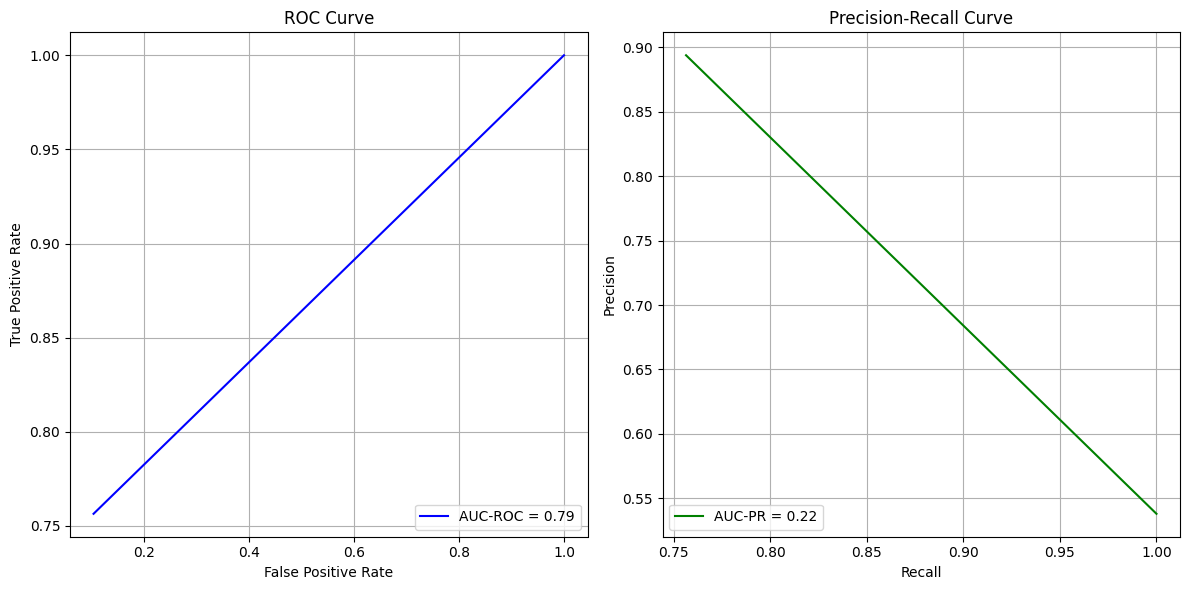

In [22]:
def calculate_tpr_fpr(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    tpr = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    return tpr, fpr, precision, recall

roc_points = [calculate_tpr_fpr(labels, y_scores, t) for t in np.linspace(0, 1, 100)]
tpr_vals, fpr_vals, prec_vals, rec_vals = zip(*roc_points)

auc_roc = np.trapz(sorted(tpr_vals), sorted(fpr_vals))
auc_pr = np.trapz(sorted(prec_vals), sorted(rec_vals))
print(f"AUC-ROC: {auc_roc}, AUC-PR: {auc_pr}")
